<a href="https://colab.research.google.com/github/tsai-praveen/era1-assignments/blob/main/S4/Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [2]:
# CUDA?
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("CUDA Available?", device)

CUDA Available? cuda


CODE BLOCK: 3

In [3]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
    ])

CODE BLOCK: 4

In [4]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [ ]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 91430047.58it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 129418476.31it/s]


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27602949.51it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 4610486.15it/s]


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



CODE BLOCK: 5

In [12]:
batch_size = 128

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}
test_loader = torch.utils.data.DataLoader(test_data, **kwargs)

CODE BLOCK: 6

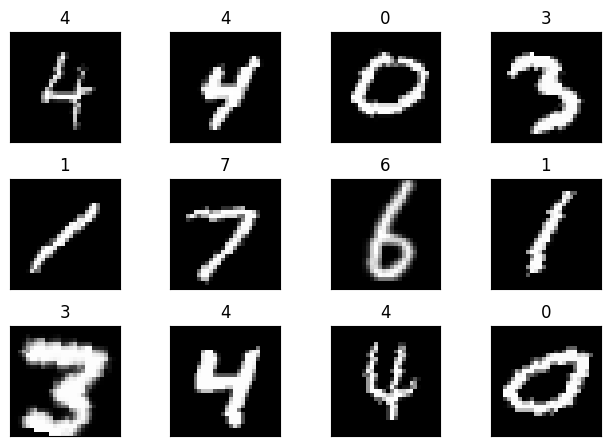

In [14]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

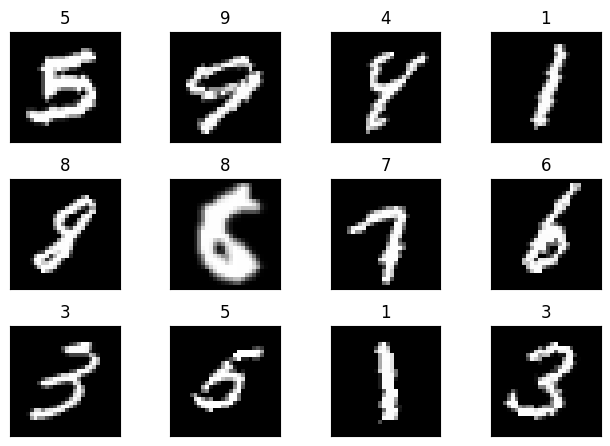

In [ ]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader)) 

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [22]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3,)     
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)    
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)   
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        # print("Shape now 1 : ", x.shape)
        x = F.relu(self.conv1(x))                                        # i: 28x28x1, o : 26x26x32, rf : 1
        # print("Shape now 2 : ", x.shape)
        x = F.max_pool2d(input=self.conv2(x), kernel_size=2, stride=2)   # i: 26x26x32, o : 12x12x64, rf : 6
        # print("Shape now 3 : ", x.shape)
        x = F.relu(self.conv3(x))                                        # i: 12x12x64, o : 10x10x128, rf : 8
        # print("Shape now 4 : ", x.shape)
        x = F.max_pool2d(self.conv4(x), kernel_size=2, stride=2)         # i: 10x10x128, o : 4x4x256, rf : 20
        # print("Shape now 5 : ", x.shape)
        x = x.view(-1, 4096)
        # print("Shape now 6 : ", x.shape)
        x = F.relu(self.fc1(x))
        # print("Shape now 7 : ", x.shape)
        x = self.fc2(x) 
        # print("Shape now 8 : ", x.shape)
        return F.log_softmax(x, dim=1)

In [23]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)     
summary(model, input_size=(1, 28, 28), batch_size=1, device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [1, 32, 26, 26]             320
            Conv2d-2            [1, 64, 24, 24]          18,496
            Conv2d-3           [1, 128, 10, 10]          73,856
            Conv2d-4             [1, 256, 8, 8]         295,168
            Linear-5                    [1, 50]         204,850
            Linear-6                    [1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------


CODE BLOCK: 8

In [24]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 8

In [25]:

from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = F.nll_loss(pred, target)
    train_loss += loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()
    
    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
     

CODE BLOCK: 9

In [26]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, test_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.1315 Batch_id=468 Accuracy=88.51: 100%|██████████| 469/469 [00:30<00:00, 15.39it/s]


Test set: Average loss: 0.0613, Accuracy: 9798/10000 (97.98%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.0391 Batch_id=468 Accuracy=97.45: 100%|██████████| 469/469 [00:27<00:00, 17.25it/s]


Test set: Average loss: 0.0380, Accuracy: 9866/10000 (98.66%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.0595 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:26<00:00, 17.84it/s]


Test set: Average loss: 0.0306, Accuracy: 9896/10000 (98.96%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.0181 Batch_id=468 Accuracy=98.53: 100%|██████████| 469/469 [00:26<00:00, 18.02it/s]


Test set: Average loss: 0.0328, Accuracy: 9884/10000 (98.84%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0064 Batch_id=468 Accuracy=98.58: 100%|██████████| 469/469 [00:26<00:00, 17.59it/s]


Test set: Average loss: 0.0290, Accuracy: 9906/10000 (99.06%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.0907 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:27<00:00, 17.23it/s]


Test set: Average loss: 0.0233, Accuracy: 9919/10000 (99.19%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0347 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:27<00:00, 16.83it/s]


Test set: Average loss: 0.0232, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0037 Batch_id=468 Accuracy=99.03: 100%|██████████| 469/469 [00:26<00:00, 17.98it/s]


Test set: Average loss: 0.0242, Accuracy: 9924/10000 (99.24%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0410 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:26<00:00, 17.90it/s]


Test set: Average loss: 0.0221, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0103 Batch_id=468 Accuracy=99.17: 100%|██████████| 469/469 [00:26<00:00, 17.94it/s]


Test set: Average loss: 0.0223, Accuracy: 9927/10000 (99.27%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0069 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:26<00:00, 17.89it/s]


Test set: Average loss: 0.0208, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0079 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:26<00:00, 17.64it/s]


Test set: Average loss: 0.0204, Accuracy: 9941/10000 (99.41%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0090 Batch_id=468 Accuracy=99.32: 100%|██████████| 469/469 [00:26<00:00, 17.46it/s]


Test set: Average loss: 0.0230, Accuracy: 9932/10000 (99.32%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0204 Batch_id=468 Accuracy=99.38: 100%|██████████| 469/469 [00:26<00:00, 17.38it/s]


Test set: Average loss: 0.0222, Accuracy: 9929/10000 (99.29%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0045 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:27<00:00, 16.82it/s]


Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0011 Batch_id=468 Accuracy=99.61: 100%|██████████| 469/469 [00:26<00:00, 17.95it/s]


Test set: Average loss: 0.0191, Accuracy: 9935/10000 (99.35%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0060 Batch_id=468 Accuracy=99.67: 100%|██████████| 469/469 [00:25<00:00, 18.05it/s]


Test set: Average loss: 0.0186, Accuracy: 9933/10000 (99.33%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0028 Batch_id=468 Accuracy=99.68: 100%|██████████| 469/469 [00:25<00:00, 18.30it/s]


Test set: Average loss: 0.0175, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.0014 Batch_id=468 Accuracy=99.70: 100%|██████████| 469/469 [00:26<00:00, 17.68it/s]


Test set: Average loss: 0.0178, Accuracy: 9938/10000 (99.38%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0054 Batch_id=468 Accuracy=99.71: 100%|██████████| 469/469 [00:25<00:00, 18.42it/s]


Test set: Average loss: 0.0177, Accuracy: 9939/10000 (99.39%)

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1, verbose=True)
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer)
  test(model, device, train_loader)
  scheduler.step()

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 1


Train: Loss=0.3130 Batch_id=117 Accuracy=72.33: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Test set: Average loss: 0.2189, Accuracy: 9645/10000 (96.45%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 2


Train: Loss=0.1857 Batch_id=117 Accuracy=95.91: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Test set: Average loss: 0.0869, Accuracy: 9800/10000 (98.00%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 3


Train: Loss=0.1129 Batch_id=117 Accuracy=97.09: 100%|██████████| 118/118 [00:25<00:00,  4.64it/s]


Test set: Average loss: 0.0528, Accuracy: 9882/10000 (98.82%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 4


Train: Loss=0.1100 Batch_id=117 Accuracy=97.57: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Test set: Average loss: 0.0429, Accuracy: 9895/10000 (98.95%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 5


Train: Loss=0.0491 Batch_id=117 Accuracy=97.98: 100%|██████████| 118/118 [00:25<00:00,  4.67it/s]


Test set: Average loss: 0.0456, Accuracy: 9868/10000 (98.68%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 6


Train: Loss=0.1447 Batch_id=117 Accuracy=98.12: 100%|██████████| 118/118 [00:26<00:00,  4.43it/s]


Test set: Average loss: 0.0353, Accuracy: 9904/10000 (99.04%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 7


Train: Loss=0.0663 Batch_id=117 Accuracy=98.19: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]


Test set: Average loss: 0.0339, Accuracy: 9908/10000 (99.08%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 8


Train: Loss=0.0555 Batch_id=117 Accuracy=98.37: 100%|██████████| 118/118 [00:29<00:00,  4.03it/s]


Test set: Average loss: 0.0290, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 9


Train: Loss=0.0154 Batch_id=117 Accuracy=98.43: 100%|██████████| 118/118 [00:25<00:00,  4.66it/s]


Test set: Average loss: 0.0268, Accuracy: 9923/10000 (99.23%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 10


Train: Loss=0.0441 Batch_id=117 Accuracy=98.42: 100%|██████████| 118/118 [00:25<00:00,  4.63it/s]


Test set: Average loss: 0.0273, Accuracy: 9920/10000 (99.20%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 11


Train: Loss=0.0154 Batch_id=117 Accuracy=98.59: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Test set: Average loss: 0.0235, Accuracy: 9928/10000 (99.28%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 12


Train: Loss=0.0417 Batch_id=117 Accuracy=98.60: 100%|██████████| 118/118 [00:25<00:00,  4.56it/s]


Test set: Average loss: 0.0246, Accuracy: 9930/10000 (99.30%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 13


Train: Loss=0.0089 Batch_id=117 Accuracy=98.55: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Test set: Average loss: 0.0273, Accuracy: 9912/10000 (99.12%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 14


Train: Loss=0.0317 Batch_id=117 Accuracy=98.69: 100%|██████████| 118/118 [00:28<00:00,  4.18it/s]


Test set: Average loss: 0.0240, Accuracy: 9926/10000 (99.26%)

Adjusting learning rate of group 0 to 1.0000e-02.
Epoch 15


Train: Loss=0.0129 Batch_id=117 Accuracy=98.79: 100%|██████████| 118/118 [00:28<00:00,  4.08it/s]


Test set: Average loss: 0.0263, Accuracy: 9916/10000 (99.16%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 16


Train: Loss=0.0381 Batch_id=117 Accuracy=98.86: 100%|██████████| 118/118 [00:30<00:00,  3.89it/s]


Test set: Average loss: 0.0199, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 17


Train: Loss=0.0462 Batch_id=117 Accuracy=98.87: 100%|██████████| 118/118 [00:27<00:00,  4.23it/s]


Test set: Average loss: 0.0194, Accuracy: 9944/10000 (99.44%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 18


Train: Loss=0.0148 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:25<00:00,  4.60it/s]


Test set: Average loss: 0.0196, Accuracy: 9943/10000 (99.43%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 19


Train: Loss=0.1126 Batch_id=117 Accuracy=98.95: 100%|██████████| 118/118 [00:25<00:00,  4.55it/s]


Test set: Average loss: 0.0195, Accuracy: 9947/10000 (99.47%)

Adjusting learning rate of group 0 to 1.0000e-03.
Epoch 20


Train: Loss=0.0188 Batch_id=117 Accuracy=98.97: 100%|██████████| 118/118 [00:26<00:00,  4.40it/s]


Test set: Average loss: 0.0197, Accuracy: 9940/10000 (99.40%)

Adjusting learning rate of group 0 to 1.0000e-03.


Text(0.5, 1.0, 'Test Accuracy')

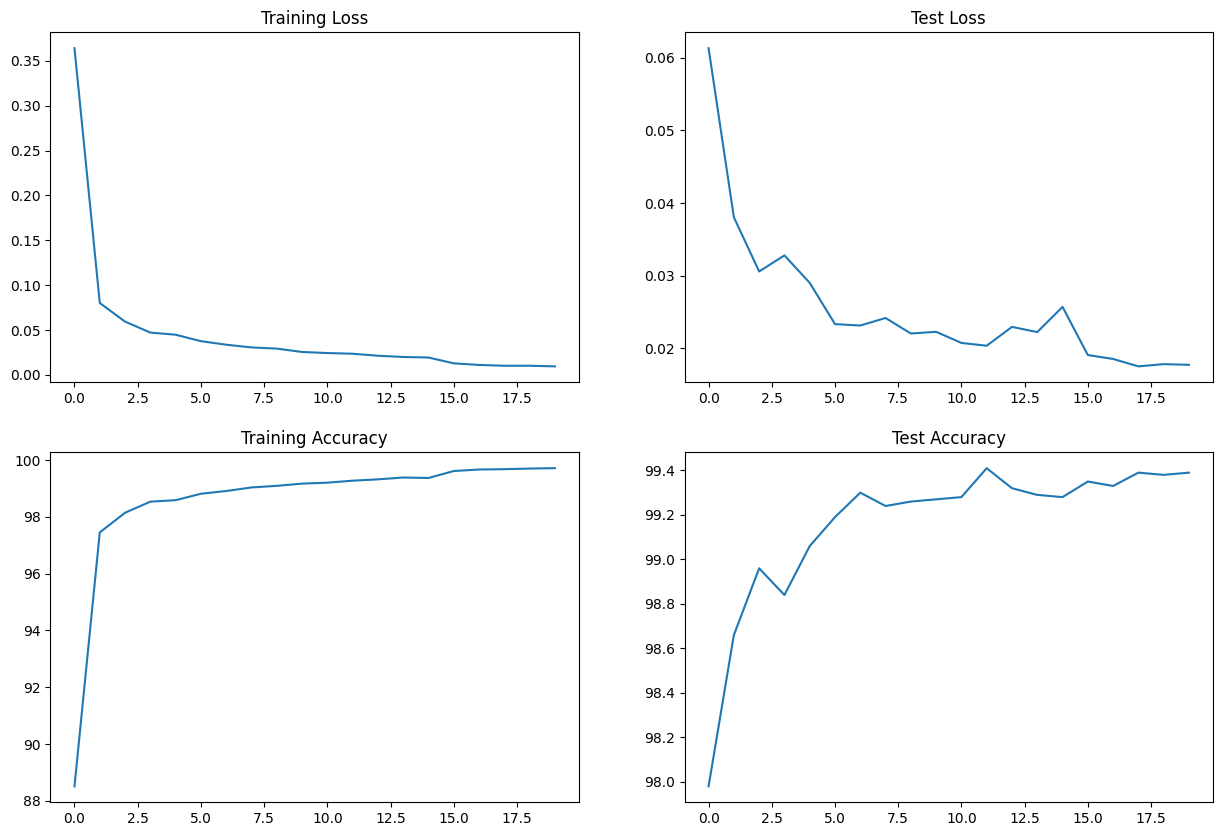

In [27]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Text(0.5, 1.0, 'Test Accuracy')

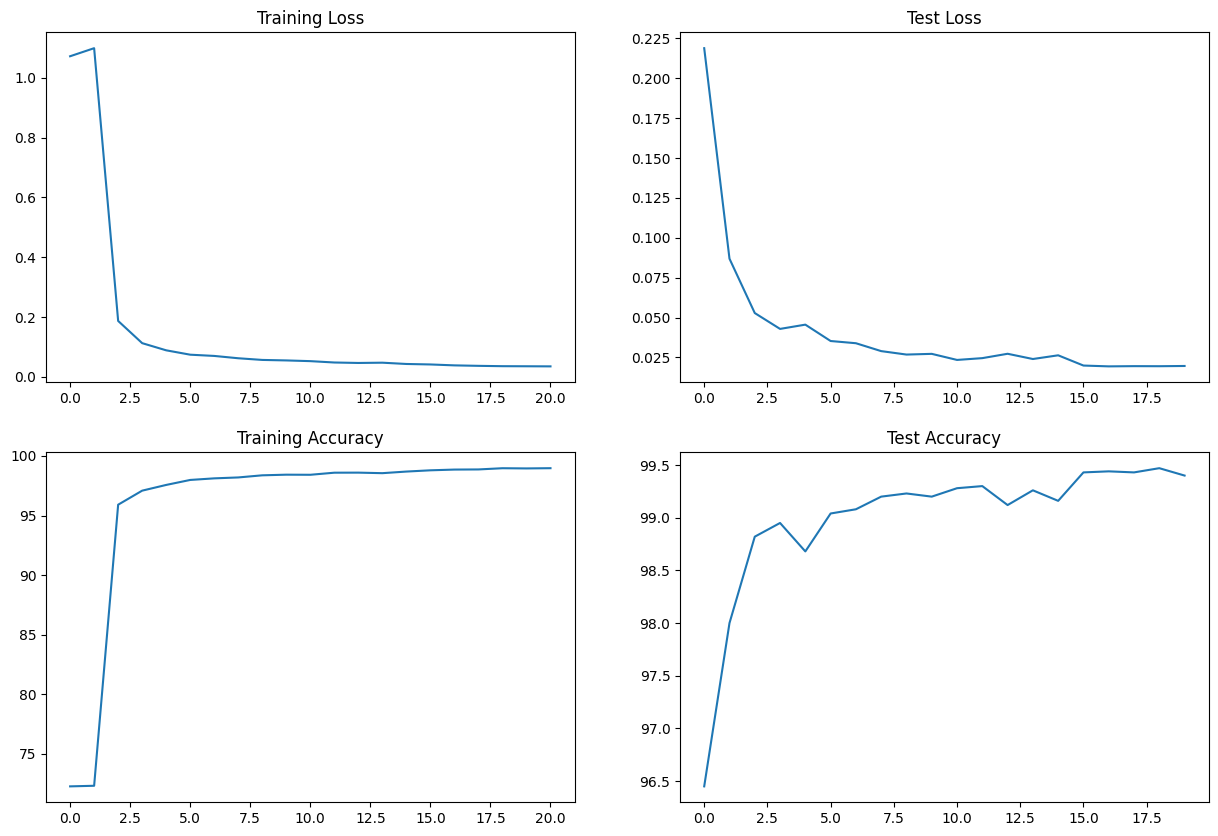

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [86]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 26, 26]             320
            Conv2d-2           [-1, 64, 24, 24]          18,496
            Conv2d-3          [-1, 128, 10, 10]          73,856
            Conv2d-4            [-1, 256, 8, 8]         295,168
            Linear-5                   [-1, 50]         204,850
            Linear-6                   [-1, 10]             510
Total params: 593,200
Trainable params: 593,200
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.67
Params size (MB): 2.26
Estimated Total Size (MB): 2.94
----------------------------------------------------------------
